In [4]:
# Import required packages
import pandas as pd
import numpy as np
import logging
import pyLDAvis.gensim
import json
import warnings
warnings.filterwarnings('ignore')  # To ignore all warnings that arise here to enhance clarity

from gensim.models.coherencemodel import CoherenceModel
from gensim.models.ldamodel import LdaModel
from gensim.corpora.dictionary import Dictionary
from numpy import array

# Import dataset
p_df = pd.read_csv('Reviews.csv')
# Create sample of 10,000 reviews
p_df = p_df.sample(n = 10000)
# Convert to array
docs =array(p_df['Text'])
# Define function for tokenize and lemmatizing
from nltk.stem.wordnet import WordNetLemmatizer
from nltk.tokenize import RegexpTokenizer

def docs_preprocessor(docs):
    tokenizer = RegexpTokenizer(r'\w+')
    for idx in range(len(docs)):
        docs[idx] = docs[idx].lower()  # Convert to lowercase.
        docs[idx] = tokenizer.tokenize(docs[idx])  # Split into words.

    # Remove numbers, but not words that contain numbers.
    docs = [[token for token in doc if not token.isdigit()] for doc in docs]
    
    # Remove words that are only one character.
    docs = [[token for token in doc if len(token) > 3] for doc in docs]
    
    # Lemmatize all words in documents.
    lemmatizer = WordNetLemmatizer()
    docs = [[lemmatizer.lemmatize(token) for token in doc] for doc in docs]
  
    return docs
# Perform function on our document
docs = docs_preprocessor(docs)
#Create Biagram & Trigram Models 
from gensim.models import Phrases
# Add bigrams and trigrams to docs,minimum count 10 means only that appear 10 times or more.
bigram = Phrases(docs, min_count=10)
trigram = Phrases(bigram[docs])

for idx in range(len(docs)):
    for token in bigram[docs[idx]]:
        if '_' in token:
            # Token is a bigram, add to document.
            docs[idx].append(token)
    for token in trigram[docs[idx]]:
        if '_' in token:
            # Token is a bigram, add to document.
            docs[idx].append(token)
#Remove rare & common tokens 
# Create a dictionary representation of the documents.
dictionary = Dictionary(docs)
dictionary.filter_extremes(no_below=10, no_above=0.2)
#Create dictionary and corpus required for Topic Modeling
corpus = [dictionary.doc2bow(doc) for doc in docs]
print('Number of unique tokens: %d' % len(dictionary))
print('Number of documents: %d' % len(corpus))
print(corpus[:1])

Number of unique tokens: 4158
Number of documents: 10000
[[(0, 1), (1, 1), (2, 1), (3, 1), (4, 1), (5, 3), (6, 1), (7, 1), (8, 1), (9, 1), (10, 1), (11, 1), (12, 1)]]


In [5]:
docs

[['dog',
  'love',
  'these',
  'treat',
  'they',
  'easy',
  'break',
  'great',
  'incentive',
  'obey',
  'have',
  'these',
  'delivered',
  'every',
  'month',
  'take',
  'pain',
  'running',
  'store',
  'every_month',
  'these_treat',
  'every_month',
  'every_month'],
 ['didn',
  'know',
  'what',
  'missing',
  'until',
  'tried',
  'this',
  'syrup',
  'been',
  'buying',
  'real',
  'maple',
  'syrup',
  'year',
  'mostly',
  'grade',
  'some',
  'grade',
  'here',
  'there',
  'nothing',
  'compare',
  'this',
  'syrup',
  'flavor',
  'fabulous',
  'rich',
  'with',
  'strong',
  'caramel',
  'taste',
  'also',
  'thicker',
  'than',
  'maple',
  'syrup',
  'ever',
  'which',
  'nice',
  'because',
  'accidentally',
  'flood',
  'plate',
  'with',
  'bottle',
  'easy',
  'pour',
  'from',
  'well',
  'price',
  'great',
  'organic',
  'will',
  'purchasing',
  'this',
  'again',
  'again',
  'didn_know',
  'been_buying',
  'maple_syrup',
  'there_nothing',
  'maple_syrup'

In [6]:
# Set parameters.
num_topics = 5
chunksize = 500 
passes = 20 
iterations = 400
eval_every = 1  

# Make a index to word dictionary.
temp = dictionary[0]  # only to "load" the dictionary.
id2word = dictionary.id2token

lda_model = LdaModel(corpus=corpus, id2word=id2word, chunksize=chunksize, \
                       alpha='auto', eta='auto', \
                       iterations=iterations, num_topics=num_topics, \
                       passes=passes, eval_every=eval_every)
# Print the Keyword in the 5 topics
print(lda_model.print_topics())

[(0, '0.013*"from" + 0.012*"food" + 0.011*"would" + 0.011*"when" + 0.009*"more" + 0.009*"will" + 0.008*"time" + 0.008*"what" + 0.007*"because" + 0.007*"amazon"'), (1, '0.016*"treat" + 0.012*"your" + 0.011*"better_than" + 0.010*"highly_recommend" + 0.009*"also" + 0.009*"little" + 0.008*"than" + 0.008*"dog" + 0.008*"snack" + 0.008*"recommend"'), (2, '0.052*"coffee" + 0.014*"drink" + 0.013*"make" + 0.011*"peanut_butter" + 0.009*"cup" + 0.009*"green" + 0.008*"strong" + 0.007*"water" + 0.007*"sauce" + 0.007*"tried"'), (3, '0.031*"chocolate" + 0.025*"grocery_store" + 0.024*"chip" + 0.023*"salt" + 0.018*"much_better" + 0.014*"just_right" + 0.014*"dark_chocolate" + 0.013*"amazon" + 0.012*"dark" + 0.012*"other_brand"'), (4, '0.026*"sugar" + 0.026*"this_stuff" + 0.022*"sweet" + 0.020*"free" + 0.019*"gluten_free" + 0.014*"stuff" + 0.013*"ingredient" + 0.011*"cooky" + 0.011*"calorie" + 0.010*"candy"')]


In [7]:
# Compute Coherence Score using c_v
coherence_model_lda = CoherenceModel(model=lda_model, texts=docs, dictionary=dictionary, coherence='c_v')
coherence_lda = coherence_model_lda.get_coherence()
print('\nCoherence Score: ', coherence_lda)


Coherence Score:  0.3831899171721755


In [8]:
# Compute Coherence Score using UMass
coherence_model_lda = CoherenceModel(model=lda_model, texts=docs, dictionary=dictionary, coherence="u_mass")
coherence_lda = coherence_model_lda.get_coherence()
print('\nCoherence Score: ', coherence_lda)


Coherence Score:  -3.1078465737404124


In [9]:
def compute_coherence_values(dictionary, corpus, texts, limit, start=2, step=3):
    """
    Compute c_v coherence for various number of topics

    Parameters:
    ----------
    dictionary : Gensim dictionary
    corpus : Gensim corpus
    texts : List of input texts
    limit : Max num of topics

    Returns:
    -------
    model_list : List of LDA topic models
    coherence_values : Coherence values corresponding to the LDA model with respective number of topics
    """
    coherence_values = []
    model_list = []
    for num_topics in range(start, limit, step):
        model=LdaModel(corpus=corpus, id2word=dictionary, num_topics=num_topics)
        model_list.append(model)
        coherencemodel = CoherenceModel(model=model, texts=texts, dictionary=dictionary, coherence='c_v')
        coherence_values.append(coherencemodel.get_coherence())

    return model_list, coherence_values

In [10]:
model_list, coherence_values = compute_coherence_values(dictionary=dictionary, corpus=corpus, texts=docs, start=2, limit=40, step=6)
# Show graph
import matplotlib.pyplot as plt
limit=40; start=2; step=6;
x = range(start, limit, step)
plt.plot(x, coherence_values)
plt.xlabel("Num Topics")
plt.ylabel("Coherence score")
plt.legend(("coherence_values"), loc='best')
plt.show()

<Figure size 640x480 with 1 Axes>

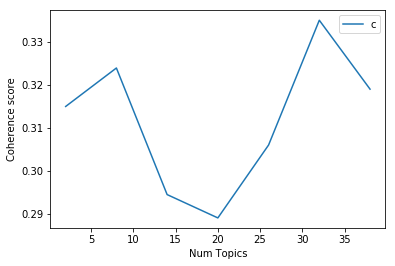

In [12]:
%matplotlib inline
import matplotlib.pyplot as plt
limit=40; start=2; step=6;
x = range(start, limit, step)
plt.plot(x, coherence_values)
plt.xlabel("Num Topics")
plt.ylabel("Coherence score")
plt.legend(("coherence_values"), loc='best')
plt.show()